<div class="alert alert-danger" role="alert">
    <span style="font-size:20px">&#9888;</span> <span style="font-size:16px">This is a read-only notebook! If you want to make and save changes, save a copy by clicking on <b>File</b> &#8594; <b>Save a copy</b>. If this is already a copy, you can delete this cell.</span>
</div>

In [1]:
# Load in Python libraries
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# Temporary Developer's code
%load_ext autoreload
%autoreload 2

In [9]:
# Add path of the folder 'resources' to the path from which we can import modules  
import sys
sys.path.append('../utilities')
from clustering.kmeans import execute_k_means, k_means_range


# Read in data

In [10]:
# Load in the data
soccer_data = pd.read_csv("sample_inputs/soccer.csv")

In [11]:
# Look at the top 10 rows
pd.set_option('display.max_columns', None) # Show all columns -- only use if needed and data is not extremely wide
soccer_data.head(10)

,player_api_id,player_name,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,foot,attack_work_rate,defense_work_rate,height,weight,attacking,skill,movement,power,mentality,defending,goalkeeping,avg,fix_crossing,fix_short_passing,fix_finishing,fix_volleys,fix_heading_accuracy,fix_dribbling,fix_curve,fix_free_kick_accuracy,fix_long_passing,fix_ball_control,fix_acceleration,fix_sprint_speed,fix_agility,fix_reactions,fix_balance,fix_shot_power,fix_jumping,fix_stamina,fix_strength,fix_long_shots,fix_aggression,fix_interceptions,fix_positioning,fix_vision,fix_penalties,fix_marking,fix_standing_tackle,fix_sliding_tackle,fix_gk_diving,fix_gk_handling,fix_gk_kicking,fix_gk_positioning,fix_gk_reflexes
0,2625,"Patryk Rachwal,18",60.5,61.0,50.0,47.0,46.0,53.0,38.0,56.0,50.0,50.0,66.0,58.0,67.0,63.0,67.0,49.0,76.0,68.0,56.0,77.0,56.0,58.0,71.0,64.0,49.0,55.0,66.0,63.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0,1.0,2.0,1,175.26,154,46.8,56.0,64.4,63.0,61.0,60.000000,9.0,50.939394,-0.939394,2.060606,-3.939394,-12.939394,-4.939394,5.060606,-0.939394,-0.939394,15.060606,7.060606,16.060606,12.060606,16.060606,-1.939394,25.060606,17.060606,5.060606,26.060606,5.060606,7.060606,20.060606,13.060606,-1.939394,4.060606,15.060606,12.060606,12.060606,3.060606,-38.939394,-39.939394,-44.939394,-42.939394,-42.939394
1,2752,Diego Mainz,70.0,71.0,36.0,37.0,72.0,55.0,20.0,45.0,30.0,16.0,60.0,56.0,39.0,34.0,43.0,62.0,42.0,57.0,55.0,59.0,84.0,17.0,82.0,72.0,31.0,52.0,35.0,74.0,73.0,65.0,11.0,6.0,7.0,9.0,15.0,1.0,2.0,1,187.96,174,44.0,41.4,44.0,54.4,54.4,70.666667,9.6,43.969697,-7.969697,11.030303,-6.969697,-23.969697,28.030303,1.030303,-13.969697,-27.969697,16.030303,12.030303,-4.969697,-9.969697,-0.969697,18.030303,-1.969697,13.030303,11.030303,15.030303,40.030303,-26.969697,38.030303,28.030303,-12.969697,8.030303,-8.969697,30.030303,29.030303,21.030303,-32.969697,-37.969697,-36.969697,-34.969697,-28.969697
2,2768,Jose Dorado,72.0,73.0,42.0,42.0,69.0,68.0,28.0,39.0,53.0,19.0,56.0,58.0,57.0,55.0,58.0,72.0,61.0,38.0,77.0,52.0,70.0,20.0,62.0,78.0,38.0,57.0,25.0,74.0,73.0,81.0,11.0,14.0,12.0,13.0,9.0,-1.0,2.0,1,180.34,154,49.8,45.0,60.6,51.4,52.0,76.000000,11.8,47.909091,-5.909091,20.090909,-5.909091,-19.909091,21.090909,-8.909091,5.090909,-28.909091,8.090909,10.090909,9.090909,7.090909,10.090909,24.090909,13.090909,-9.909091,29.090909,4.090909,22.090909,-27.909091,14.090909,30.090909,-9.909091,9.090909,-22.909091,26.090909,25.090909,33.090909,-36.909091,-33.909091,-35.909091,-34.909091,-38.909091
3,2770,Ignacio Gonzalez,71.0,72.0,62.0,68.0,71.0,72.0,69.0,71.0,84.0,71.0,70.0,76.0,63.0,54.0,63.0,65.0,62.0,72.0,56.0,47.0,61.0,74.0,56.0,41.0,70.0,73.0,69.0,33.0,43.0,25.0,12.0,13.0,6.0,14.0,15.0,1.0,2.0,1,180.34,161,68.4,74.4,61.4,62.0,61.8,33.666667,12.0,54.575758,7.424242,17.424242,13.424242,14.424242,16.424242,16.424242,29.424242,16.424242,15.424242,21.424242,8.424242,-0.575758,8.424242,10.424242,7.424242,17.424242,1.424242,-7.575758,6.424242,19.424242,1.424242,-13.575758,15.424242,18.424242,14.424242,-21.575758,-11.575758,-29.575758,-42.575758,-41.575758,-48.575758,-40.575758,-39.575758
4,2790,Alberto Rey,71.0,76.0,71.0,37.0,55.0,68.0,43.0,64.0,67.0,56.0,71.0,67.0,71.0,71.0,65.0,69.0,67.0,46.0,61.0,75.0,72.0,42.0,67.0,60.0,62.0,60.0,54.0,77.0,77.0,69.0,8.0,21.0,71.0,21.0,21.0,-1.0,0.0,1,175.26,163,54.8,65.0,68.6,59.2,60.6,74.333333,28.4,57.757576,13.242424,10.242424,-20.757576,-14.757576,-2.757576,6.242424,9.242424,-1.757576,13.242424,9.242424,13.242424,13.242424,7.242424,11.242424,9.242424,-11.757576,3.242424,17.242424,14.242424,-15.757576,9.242424,2.242424,4.242424,2.242424,-3.757576,19.242424,19.242424,11.242424,-49.757576,-36.7575

### Other type of optional pre-processing to be added 

# Perform K-means analysis for a specific number of clusters

{'model': KMeans(n_clusters=3),
 'data':        crossing  finishing  heading_accuracy  short_passing  dribbling  \
 0     -0.197272  -0.051789         -0.643964      -0.569205  -0.084118   
 1     -1.028760  -0.589339          0.968500      -0.424591  -0.717897   
 2     -0.672408  -0.320564          0.782446       0.515402  -1.063594   
 3      0.515431   1.077065          0.906482       0.804630   0.780125   
 4      1.049958  -0.589339         -0.085803       0.515402   0.376811   
 ...         ...        ...               ...            ...        ...   
 10577 -0.672408  -0.213054         -0.581946      -0.135362  -0.084118   
 10578  0.099687  -1.073133         -0.395893      -1.870734   0.549660   
 10579 -0.316056  -1.180643          0.038232      -0.858434  -0.948362   
 10580 -1.088152   0.485761         -0.085803      -0.063055   0.031114   
 10581 -0.375448  -0.481829         -0.209839      -0.063055  -0.199351   
 
        free_kick_accuracy  sprint_speed  ball_control  re

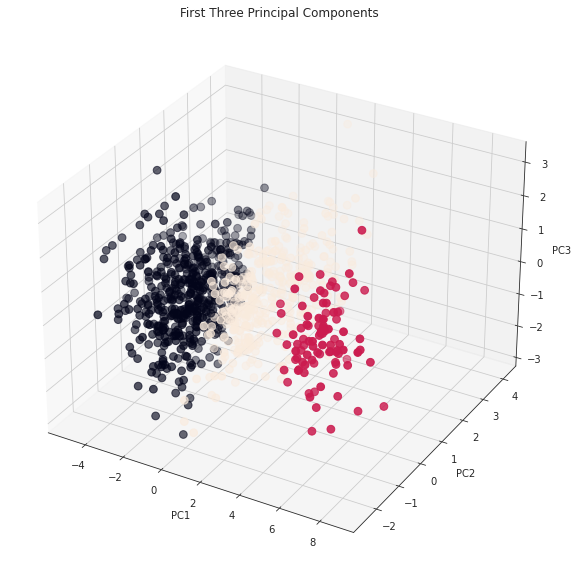

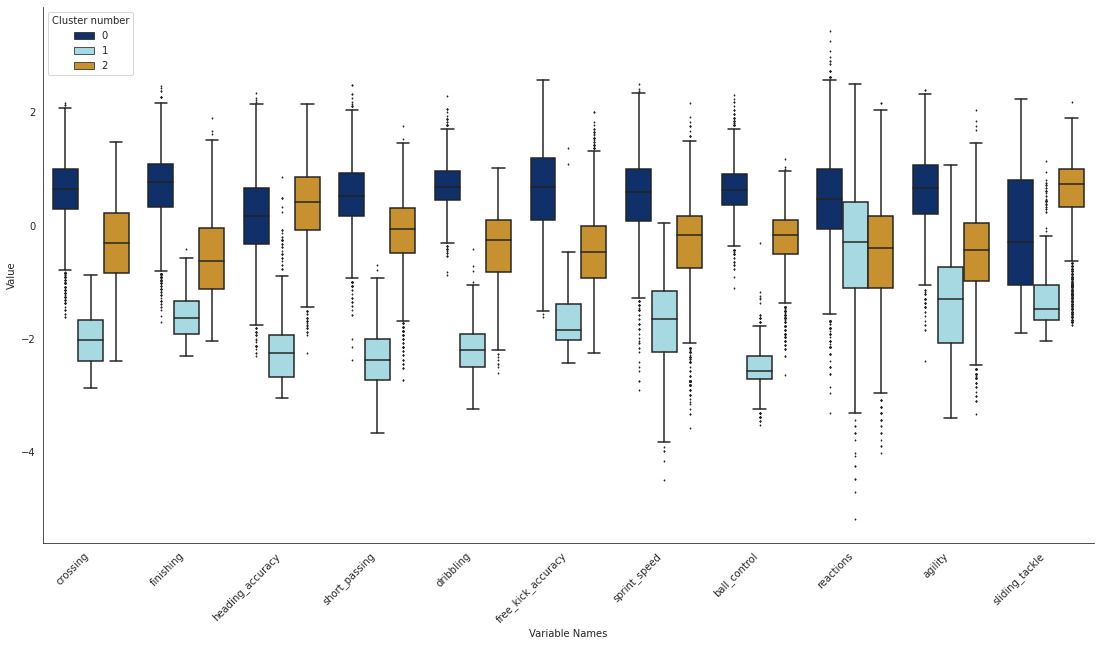

In [55]:
from clustering.kmeans import execute_k_means, k_means_range
import seaborn as sns

sns.set_style("white")

variable_names = [
    'crossing', 'finishing', 'heading_accuracy', 'short_passing',
    'dribbling', 'free_kick_accuracy', 'sprint_speed', 'ball_control', 
    'reactions', 'agility', 'sliding_tackle'
]

execute_k_means(
    dataset=soccer_data, 
    variables=variable_names,
    num_clusters=3, 
    standardize_vars=True, 
    generate_charts=True
)

# OK: resize the 3d scatterplot
# OK: display the seaborn plot
# TODO: export results to excel (either having an option on the function or with a separated function "to_excel" see what is best)

# TODO: Include more clustering methods to this template.
# TODO: Include the dimensionality reduction methods to the notebooks (add as a requirement for the clustering template) 

# Perform K-means analysis for a range of clusters

Working on 2 clusters
Working on 3 clusters
Working on 4 clusters
Working on 5 clusters


{2: {'model': KMeans(n_clusters=2),
  'data':        crossing  finishing  heading_accuracy  short_passing  dribbling  \
  0     -0.197272  -0.051789         -0.643964      -0.569205  -0.084118   
  1     -1.028760  -0.589339          0.968500      -0.424591  -0.717897   
  2     -0.672408  -0.320564          0.782446       0.515402  -1.063594   
  3      0.515431   1.077065          0.906482       0.804630   0.780125   
  4      1.049958  -0.589339         -0.085803       0.515402   0.376811   
  ...         ...        ...               ...            ...        ...   
  10577 -0.672408  -0.213054         -0.581946      -0.135362  -0.084118   
  10578  0.099687  -1.073133         -0.395893      -1.870734   0.549660   
  10579 -0.316056  -1.180643          0.038232      -0.858434  -0.948362   
  10580 -1.088152   0.485761         -0.085803      -0.063055   0.031114   
  10581 -0.375448  -0.481829         -0.209839      -0.063055  -0.199351   
  
         free_kick_accuracy  sprint_speed

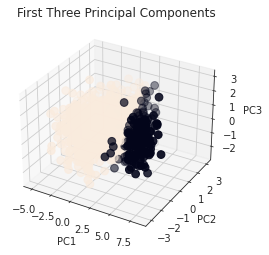

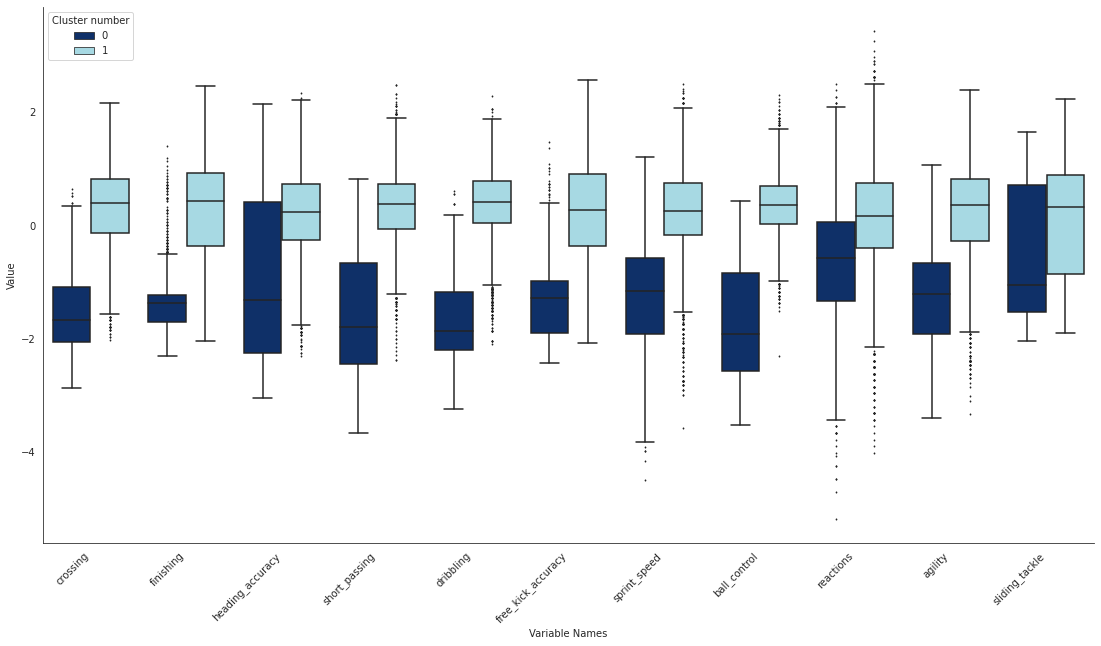

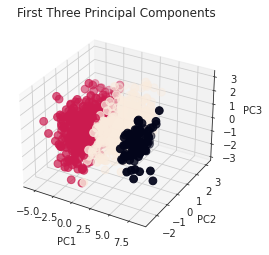

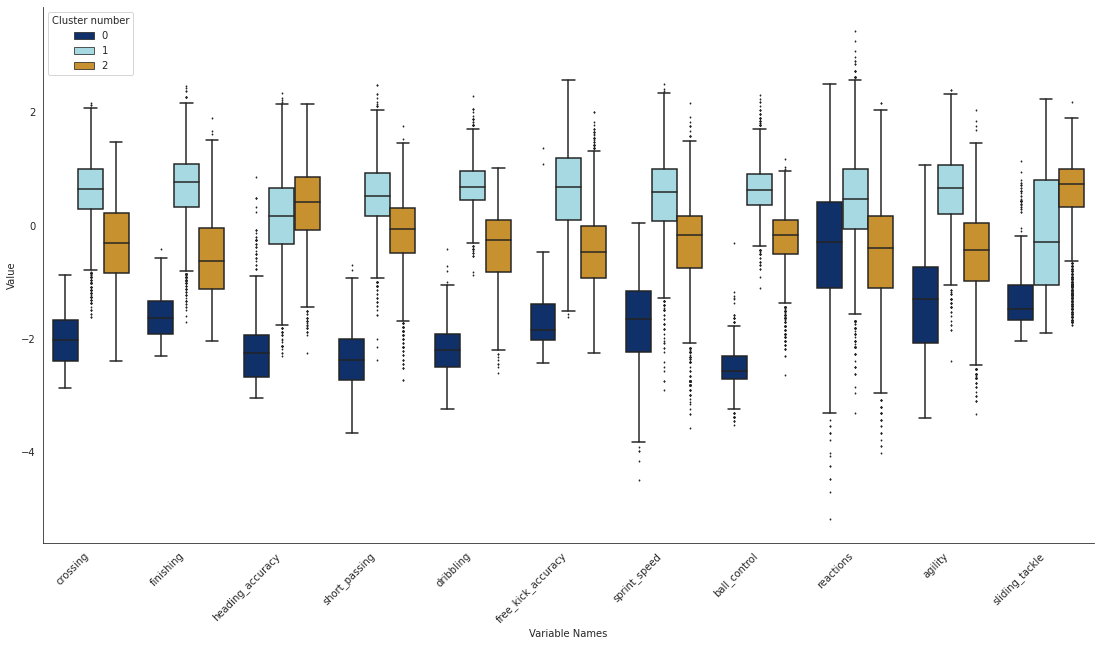

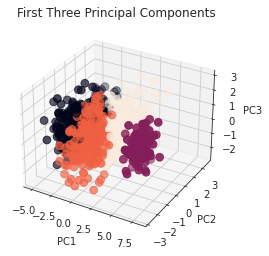

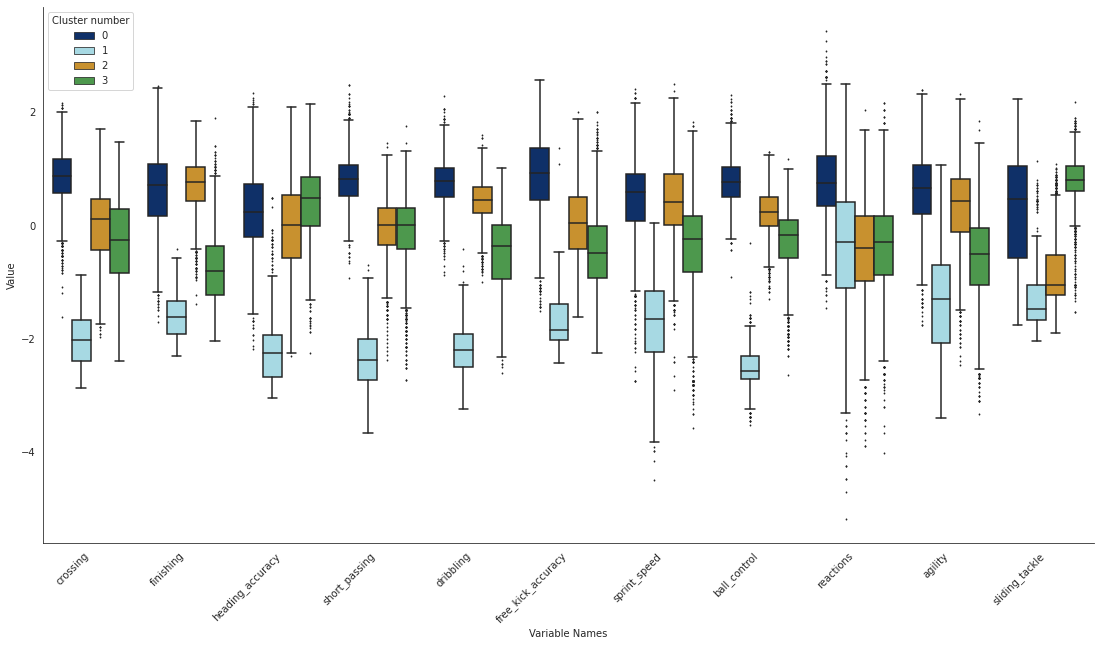

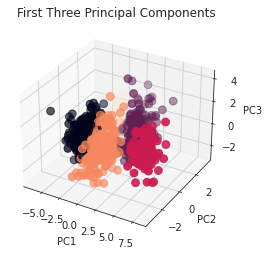

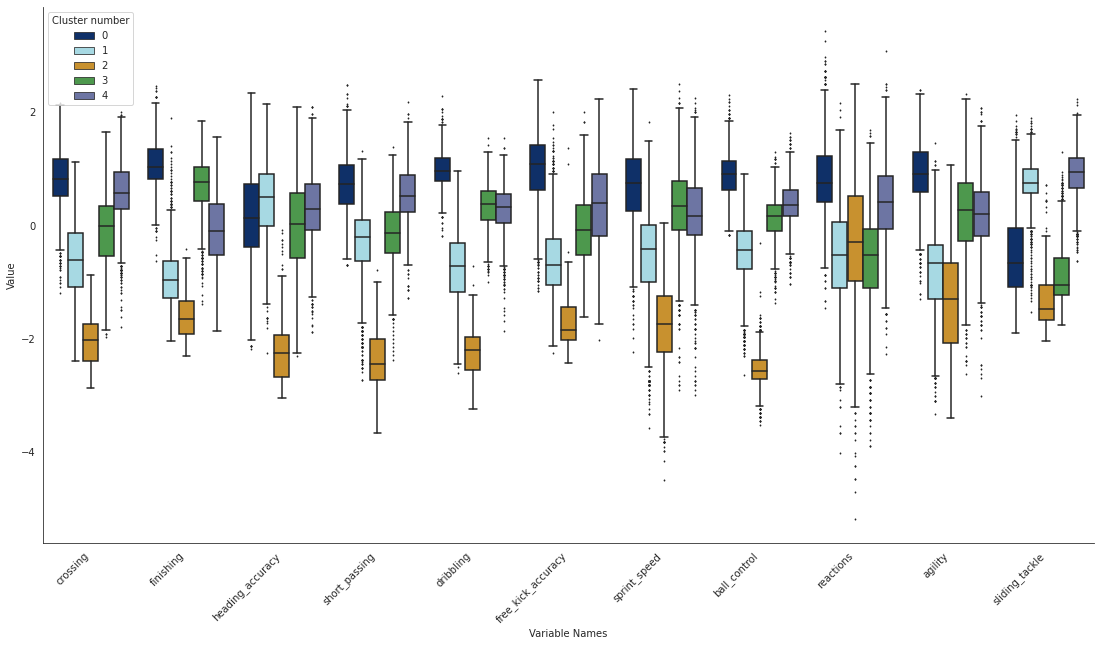

In [53]:
k_means_range(
    dataset=soccer_data, 
    variables=variable_names,
    min_clusters = 2, max_clusters = 5,
    standardize_vars = True, 
    generate_charts = True
)